## Trigger word rnn model

This notebook is dedicated to developing the rnn model to support this trigger word detection task. The rnn model being implemented for this task consists of a conv1D step to make the input_size=(1,1375,#filters) including dropout and batch normalization, and a multilayered rnn consisting of two GRU cells and dropout. All dropout has a keep_prob=0.8.

In order the show an example of using this model, I will be using the trained model to predict where a trigger word is said in an input and compare that vector to the actual vector of when the trigger word is said.

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import latex
import spacy
import math
import IPython
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
np.random.seed(10)
import keras.backend as k

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Loading data
X_data = np.load("../../data/trigger_word/data/x.npy")
y_data = np.load("../../data/trigger_word/data/y.npy")

In [7]:
X_data.shape = (1000,1402,118)
y_data.shape = (1000,1375)

In [8]:
# Training data will be first 10 recordings, and these are unshuffled sets of training ex.
X_train = X_data[10:] # unshuffled
y_train = y_data[10:]
X_test = X_data[:10]
y_test = y_data[:10]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(990, 1402, 118)
(990, 1375)
(10, 1402, 118)
(10, 1375)


In [9]:
# Placeholder functions for model input
def get_placeholders():
    X = tf.placeholder(tf.float32, shape=[None,1402,118], name='X')
    y = tf.placeholder(tf.float32, shape=[None,1375], name='Y')
    return X,y

In [10]:
# Forward prop step consisting of conv 1d, multilayered rnn, and dropout usage
def rnn_cell(the_input):
    # Conv 1D step:
    Z = tf.layers.conv1d(the_input,filters=196,kernel_size=28,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    Bn = tf.layers.batch_normalization(Z)
    A = tf.nn.relu(Bn)
    D = tf.nn.dropout(A,keep_prob=0.8)
    
    # Multilayered GRU units with dropout:
    cell1 = tf.nn.rnn_cell.GRUCell(128,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    cell1 = tf.nn.rnn_cell.DropoutWrapper(cell1,output_keep_prob=0.8)
    cell2 = tf.nn.rnn_cell.GRUCell(128,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    cell2 = tf.nn.rnn_cell.DropoutWrapper(cell2,output_keep_prob=0.8)
    
    multi_cell = tf.nn.rnn_cell.MultiRNNCell([cell1,cell2]) # multilayered cell
    outputs,curr_state = tf.nn.dynamic_rnn(multi_cell,inputs=D,dtype=tf.float32)
    
    flats = tf.map_fn(lambda x: tf.layers.flatten(x),outputs)
    out = tf.map_fn(lambda x: tf.layers.dense(x,1,activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0),reuse=tf.AUTO_REUSE),flats)
    out = tf.reshape(out,[1,1375])
    #flats = [tf.layers.flatten(out) for out in outputs] # - for eager_execution
    #out = [tf.layers.dense(flat,1,activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer(),reuse=tf.AUTO_REUSE) for flat in flats]
    
    return out

In [11]:
# Cost function, uses sigmoid cross entropy with logits to compare the predictions at each 1375 step
def cost_function(logits,y):
    return tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=y,logits=logits))

In [12]:
# Sigmoid prediction for a given vector of logits, returns both a sigmoid activation output and discrete classes - 0,1
def prediction(logits):
    sigmoid_out = tf.nn.sigmoid(logits)
    desc_out = tf.to_int32(sigmoid_out > 0.5)
    return sigmoid_out,desc_out

In [13]:
# Testing forward prop and cost function
# Example cost is large because sigmoid cross entropy is being used on 1375 epochs per training example
ax = X_train[0]
ax.shape = (1,1402, 118)
ay = y_train[0]
ay.shape = (1,1375)
tf.reset_default_graph()
x,y = get_placeholders()
out = rnn_cell(x)
cost = cost_function(out,y)
pred = prediction(out)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    aout = sess.run(out,feed_dict={x:ax,y:ay})
    acost = sess.run(cost,feed_dict={x:ax,y:ay})
    apred,adesc_pred = sess.run(pred,feed_dict={x:ax,y:ay})
    print("output shape:",aout.shape)
    print("example cost:",acost)
    print("example predictions:",apred)
    print("descrete predictions:",adesc_pred)

output shape: (1, 1375)
example cost: 1196.4111
example predictions: [[0.4194148  0.44809484 0.39459923 ... 0.55335313 0.5448271  0.5622999 ]]
descrete predictions: [[0 0 0 ... 1 1 1]]


In [14]:
# Model for trigger word detection using stochastic gradient descent w/ gradient clipping
def model(X_train,y_train,lr=0.0001,num_epochs=25,retrain=True,print_each=True):
    tf.reset_default_graph() # resetting graph
    tf.set_random_seed(1)
    seed=0
    costs=[]
    
    x,y = get_placeholders()
    logits = rnn_cell(x)
    cost = cost_function(logits,y)
    pred = prediction(logits) # get binary predictions and sigmoid activation output
    
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    grads, variables = zip(*optimizer.compute_gradients(cost))
    grads, _ = tf.clip_by_global_norm(grads, 5.0) # gradient clipping
    optimizer = optimizer.apply_gradients(zip(grads, variables))
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() # to save/load model
    with tf.Session() as sess:
        if retrain:
            saver = tf.train.import_meta_graph("../../data/trigger_word/model/trigger_model.ckpt.meta")
            saver.restore(sess, "../../data/trigger_word/model/trigger_model.ckpt")
        else:
            sess.run(init) # only run init when you are training a new model

        for epoch in range(num_epochs):
            running_cost = 0
            seed += 1
            X_train = shuffle(X_train,random_state=seed) # shuffle data for each epoch
            y_train = shuffle(y_train,random_state=seed)
            training_set = [(X_train[i],y_train[i]) for i in range(len(X_train))]
                
            for aset in training_set:
                (ax,ay) = aset
                ax.shape = (1,1402, 118)
                ay.shape = (1,1375)
                _,temp_cost = sess.run([optimizer,cost], feed_dict={x:ax,y:ay})
                if print_each:
                    print("cost increase:",temp_cost)
                running_cost += temp_cost
                
            costs.append(running_cost)
            if (epoch+1) % 1 == 0: # printing costs
                print("Cost at epoch {}: {}".format(epoch+1,running_cost))
                # model saved on every iteration
                loc = saver.save(sess, "../../data/trigger_word/model/trigger_model.ckpt")

        return costs

### Training model

In [ ]:
costs1 = model(X_train,y_train,lr=0.0001,num_epochs=25,retrain=False,print_each=False)

In [14]:
# Trying a larger learning rate
costs2 = model(X_train,y_train,lr=0.0001,num_epochs=5,retrain=False,print_each=False)

Cost at epoch 1: 180428.75931048393
Cost at epoch 2: 157693.60636144876
Cost at epoch 3: 165857.31022961438
Cost at epoch 4: 166103.2498142589
Cost at epoch 5: 169663.24153640028


In [15]:
# larger learning rate continued
costs3 = model(X_train,y_train,lr=0.0001,num_epochs=10,retrain=True,print_each=False)

INFO:tensorflow:Restoring parameters from ../../data/trigger_word/model/trigger_model.ckpt
Cost at epoch 1: 172604.286734418
Cost at epoch 2: 167082.77714821696
Cost at epoch 3: 168592.5567279081
Cost at epoch 4: 166215.8763563633
Cost at epoch 5: 165453.86967379553
Cost at epoch 6: 168843.54679752816
Cost at epoch 7: 166105.15663602226
Cost at epoch 8: 163386.02385990974
Cost at epoch 9: 163651.21607107995
Cost at epoch 10: 160606.52360264678


In [16]:
# larger learning rate continued 2
costs4 = model(X_train,y_train,lr=0.0001,num_epochs=20,retrain=True,print_each=False)

INFO:tensorflow:Restoring parameters from ../../data/trigger_word/model/trigger_model.ckpt
Cost at epoch 1: 158950.16111358372
Cost at epoch 2: 158980.74351828918
Cost at epoch 3: 159270.3915310232
Cost at epoch 4: 154315.46148476948
Cost at epoch 5: 152650.32193743775
Cost at epoch 6: 156711.37297421787
Cost at epoch 7: 154782.43429995805
Cost at epoch 8: 154369.94931139844
Cost at epoch 9: 155614.27802518138
Cost at epoch 10: 147343.32669288665
Cost at epoch 11: 150924.97515181522
Cost at epoch 12: 147602.06775993097
Cost at epoch 13: 149831.6654211632
Cost at epoch 14: 144175.16406896256
Cost at epoch 15: 141785.08557637234
Cost at epoch 16: 145146.41476965207
Cost at epoch 17: 146205.69847658311
Cost at epoch 18: 146157.32391920325
Cost at epoch 19: 140660.09865536576
Cost at epoch 20: 138748.14003429242


In [17]:
# larger learning rate continued 3
costs5 = model(X_train,y_train,lr=0.0001,num_epochs=50,retrain=True,print_each=False)

INFO:tensorflow:Restoring parameters from ../../data/trigger_word/model/trigger_model.ckpt
Cost at epoch 1: 137152.8580857544
Cost at epoch 2: 142050.0368241648
Cost at epoch 3: 138317.9367807575
Cost at epoch 4: 135814.56628690835
Cost at epoch 5: 134890.19455060823
Cost at epoch 6: 138012.60456211359
Cost at epoch 7: 134911.13769412262
Cost at epoch 8: 135058.77411720506
Cost at epoch 9: 132960.56513901957
Cost at epoch 10: 130176.60238418833
Cost at epoch 11: 130085.69411841175
Cost at epoch 12: 130346.11749324587
Cost at epoch 13: 133083.2691483703
Cost at epoch 14: 132824.62220138806
Cost at epoch 15: 130153.50181298563
Cost at epoch 16: 131992.8075261684
Cost at epoch 17: 126759.90295687824
Cost at epoch 18: 132715.94954456092
Cost at epoch 19: 132161.88218967518
Cost at epoch 20: 132146.10376887568
Cost at epoch 21: 129995.72912793636
Cost at epoch 22: 134540.27922125562
Cost at epoch 23: 129897.64990237431
Cost at epoch 24: 126697.89760418324
Cost at epoch 25: 125309.6685392177

In [18]:
# larger learning rate continued 4
costs6 = model(X_train,y_train,lr=0.0001,num_epochs=50,retrain=True,print_each=False)

INFO:tensorflow:Restoring parameters from ../../data/trigger_word/model/trigger_model.ckpt
Cost at epoch 1: 113639.44023790545
Cost at epoch 2: 114291.62401604388
Cost at epoch 3: 116830.2502002414
Cost at epoch 4: 110691.96412785578
Cost at epoch 5: 115241.59922570892
Cost at epoch 6: 118076.0693718043
Cost at epoch 7: 117043.35481344286
Cost at epoch 8: 109554.39655143002
Cost at epoch 9: 117883.1792381847
Cost at epoch 10: 116539.99671837261
Cost at epoch 11: 117456.62231497571
Cost at epoch 12: 112646.14714670993
Cost at epoch 13: 114491.70261825816
Cost at epoch 14: 113530.92031286345
Cost at epoch 15: 116095.19758734416
Cost at epoch 16: 114262.7847521872
Cost at epoch 17: 110648.77242317863
Cost at epoch 18: 118556.14181964644
Cost at epoch 19: 116734.17517398152
Cost at epoch 20: 115650.20181536215
Cost at epoch 21: 114514.04804698797
Cost at epoch 22: 117303.91868815554
Cost at epoch 23: 112561.44179083186
Cost at epoch 24: 118512.29901019539
Cost at epoch 25: 115298.612739738

KeyboardInterrupt: 

In [20]:
# larger learning rate continued 5
costs7 = model(X_train,y_train,lr=0.00003,num_epochs=50,retrain=True,print_each=False)

INFO:tensorflow:Restoring parameters from ../../data/trigger_word/model/trigger_model.ckpt
Cost at epoch 1: 99360.12099144659
Cost at epoch 2: 102315.47637244323
Cost at epoch 3: 103508.85551199148
Cost at epoch 4: 102581.13697452609
Cost at epoch 5: 100928.9028616848
Cost at epoch 6: 98560.90726381425
Cost at epoch 7: 96840.09070160604
Cost at epoch 8: 96847.94090327172
Cost at epoch 9: 97790.60797473195
Cost at epoch 10: 93105.03018397669
Cost at epoch 11: 98949.1538252019
Cost at epoch 12: 95146.59035982224
Cost at epoch 13: 93415.6322663174
Cost at epoch 14: 93250.73892117338
Cost at epoch 15: 93063.47179767114
Cost at epoch 16: 92915.46186030038
Cost at epoch 17: 92882.50190619286
Cost at epoch 18: 88323.87355438221
Cost at epoch 19: 93562.64667045341
Cost at epoch 20: 95794.04221132208
Cost at epoch 21: 88088.47521662997
Cost at epoch 22: 91791.36221541851
Cost at epoch 23: 88714.26970255161
Cost at epoch 24: 91377.13783074284
Cost at epoch 25: 92497.68774465942
Cost at epoch 26:

In [21]:
# larger learning rate continued 6
costs8 = model(X_train,y_train,lr=0.00003,num_epochs=50,retrain=True,print_each=False)

INFO:tensorflow:Restoring parameters from ../../data/trigger_word/model/trigger_model.ckpt
Cost at epoch 1: 81450.96254755624
Cost at epoch 2: 81915.785391192
Cost at epoch 3: 83553.80389026557
Cost at epoch 4: 78558.3381015022
Cost at epoch 5: 81433.74648849064
Cost at epoch 6: 83733.27243638734
Cost at epoch 7: 80538.01799560241
Cost at epoch 8: 78181.47203765924
Cost at epoch 9: 79019.729814703
Cost at epoch 10: 76806.66617663976
Cost at epoch 11: 82115.4333951268
Cost at epoch 12: 79317.69693452152
Cost at epoch 13: 79277.647098245
Cost at epoch 14: 83437.94343899381
Cost at epoch 15: 81316.51396688005
Cost at epoch 16: 81874.03754762672
Cost at epoch 17: 78368.89075154136
Cost at epoch 18: 75286.53110797975
Cost at epoch 19: 76173.99259484191
Cost at epoch 20: 80382.12060736753
Cost at epoch 21: 76788.22145192823
Cost at epoch 22: 77722.74012487473
Cost at epoch 23: 78566.69034384536
Cost at epoch 24: 80319.43539641121
Cost at epoch 25: 77139.9605901767
Cost at epoch 26: 71006.009

KeyboardInterrupt: 

In [22]:
# larger learning rate continued 7
costs9 = model(X_train,y_train,lr=0.00001,num_epochs=50,retrain=True,print_each=False)

INFO:tensorflow:Restoring parameters from ../../data/trigger_word/model/trigger_model.ckpt
Cost at epoch 1: 73877.56476252449
Cost at epoch 2: 70416.65863850442
Cost at epoch 3: 71312.63145093631
Cost at epoch 4: 74531.27124352279
Cost at epoch 5: 70446.6981065905
Cost at epoch 6: 70745.42082512236
Cost at epoch 7: 75010.58718026716
Cost at epoch 8: 68150.76690712605
Cost at epoch 9: 72038.3844681915
Cost at epoch 10: 70011.78688705077
Cost at epoch 11: 68582.6338937618
Cost at epoch 12: 69047.58358520166
Cost at epoch 13: 69872.09721628306
Cost at epoch 14: 69923.28239586361
Cost at epoch 15: 73527.94570641767
Cost at epoch 16: 68882.51135105008
Cost at epoch 17: 70453.7691231588
Cost at epoch 18: 69224.87015858456
Cost at epoch 19: 64206.52367055991
Cost at epoch 20: 71611.69243729197
Cost at epoch 21: 67501.65165368006
Cost at epoch 22: 66712.76392775952
Cost at epoch 23: 68429.747614861
Cost at epoch 24: 68448.05729531139
Cost at epoch 25: 66704.46045635868
Cost at epoch 26: 63759.

KeyboardInterrupt: 

In [23]:
# larger learning rate continued 8
costs10 = model(X_train,y_train,lr=0.000003,num_epochs=10,retrain=True,print_each=False)

INFO:tensorflow:Restoring parameters from ../../data/trigger_word/model/trigger_model.ckpt
Cost at epoch 1: 67185.0190828089
Cost at epoch 2: 66890.07596069232
Cost at epoch 3: 67197.27429534469
Cost at epoch 4: 65510.968906483424
Cost at epoch 5: 66934.58997386572
Cost at epoch 6: 65073.58649343896
Cost at epoch 7: 68060.65244211291
Cost at epoch 8: 62688.56348277206


KeyboardInterrupt: 

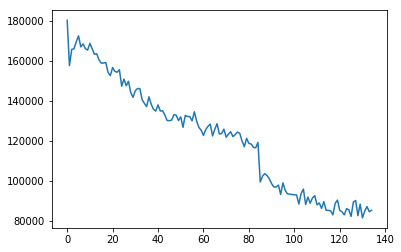

In [24]:
# Sample of the high level of variability in cost over time
tot_cost = costs2 + costs3 + costs4 + costs5 + costs7
x_i = [i for i in range(len(tot_cost))]
plt.plot(x_i,tot_cost)
plt.show()

### Predicting using the model

In [24]:
# Getting a prediction for a particular input audio clip
ax = X_train[956]
ax.shape = (1,1402, 118)

tf.reset_default_graph() # computation graph to get binary predictions
x,y = get_placeholders()
out = rnn_cell(x)
pred = prediction(out)

saver = tf.train.Saver()
with tf.Session() as sess:
    saver = tf.train.import_meta_graph("../../data/trigger_word/model/trigger_model.ckpt.meta")
    saver.restore(sess, "../../data/trigger_word/model/trigger_model.ckpt")
    apred,adesc_pred = sess.run(pred,feed_dict={x:ax})
    print("descrete predictions:",adesc_pred)

INFO:tensorflow:Restoring parameters from ../../data/trigger_word/model/trigger_model.ckpt
descrete predictions: [[0 0 0 ... 0 0 0]]


In [25]:
act_y = y_train[956]
act_y.shape = (1375)
pred_y = adesc_pred
pred_y.shape = (1375)

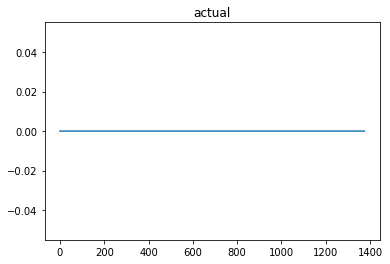

In [14]:
plt.plot(act_y)
plt.title("actual")
plt.show()

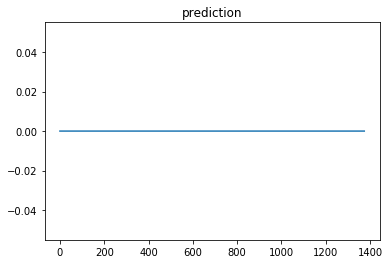

In [15]:
plt.plot(pred_y)
plt.title("prediction")
plt.show()

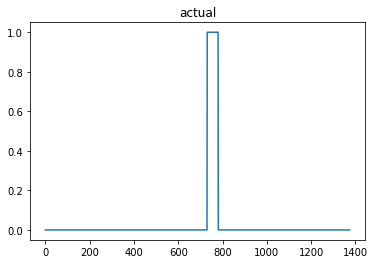

In [26]:
plt.plot(act_y)
plt.title("actual")
plt.show()

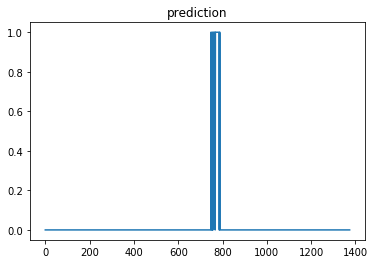

In [27]:
plt.plot(pred_y)
plt.title("prediction")
plt.show()